# Відбіркового етапу IASA DATA SCIENCE CHAMP 2022

__by Д.Кнут і пряники__

## Імпорт бібліотек

In [36]:
import numpy as np
import pandas as pd
import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Попередній аналіз даних

In [2]:
data = pd.read_csv(r'D:\IASA\DS Champ 2022\TEST TASK (dataset).csv')

Для початку дізнаємося типи даних, що були зібрані про гравців, і кількість non-null значень в кожній з них.

In [3]:
data.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1467832 entries, 0 to 1467831
Data columns (total 63 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   total_sessions_day0         1466467 non-null  float64
 1   total_sessions_day1         1466465 non-null  float64
 2   total_sessions_day3         1466464 non-null  float64
 3   total_sessions_day7         1466458 non-null  float64
 4   chapters_finished_day0      1467832 non-null  int64  
 5   chapters_finished_day1      1467832 non-null  int64  
 6   chapters_finished_day3      1467832 non-null  int64  
 7   chapters_finished_day7      1467832 non-null  int64  
 8   chapters_opened_day0        1467832 non-null  int64  
 9   chapters_opened_day1        1467832 non-null  int64  
 10  chapters_opened_day3        1467832 non-null  int64  
 11  chapters_opened_day7        1467832 non-null  int64  
 12  chapters_closed_day0        1467832 non-null  int64  
 1

Більшість стовпців містять цілі й числа з рухомою комою, але маємо чотири стовпці типу об'єкт - media_source, install_date, country_code, platform. Пізніше їх потрібно буде закодувати. 
Також, можемо побачити, що деякі стовпці мають null значення. Виведемо їх.

In [4]:
null_col = data.columns[data.isnull( ).any()]

pd.Series(data[null_col].isnull( ).sum(), index=null_col)

total_sessions_day0    1365
total_sessions_day1    1367
total_sessions_day3    1368
total_sessions_day7    1374
dtype: int64

Стовпці з кумулятивними кількостями сесій містять null значення. Оскільки ми не маємо жодного уявлення про внутрішню будову додатку, null може мати різну тлумачення:
* окреме значення, що несе сенс,
* втрачене значення.

Ми зробили припущення, що null в стовпцях total_sessions_day{N} може значити, що користувач не заходив в гру, тобто мати сенс нуля сесій.

In [5]:
print("Value 0. in 'total_sessions_day0': ", pd.Series(data['total_sessions_day0'] == 0).any())
print("Value 0. in 'total_sessions_day1': ", pd.Series(data['total_sessions_day1'] == 0).any())
print("Value 0. in 'total_sessions_day3': ", pd.Series(data['total_sessions_day3'] == 0).any())
print("Value 0. in 'total_sessions_day7': ", pd.Series(data['total_sessions_day7'] == 0).any())

Value 0. in 'total_sessions_day0':  True
Value 0. in 'total_sessions_day1':  True
Value 0. in 'total_sessions_day3':  True
Value 0. in 'total_sessions_day7':  True


Припущення не знайшло підтвердження, оскільки нульове значення наявне в наборі даних. Тому будемо розглядати null як втрачене значення. Подивимося загальну кількість записів, що містять хоча б один null, і їх процент від усіх даних.

In [6]:
null_row = data.shape[0] - data.dropna().shape[0]
print(f'Number of rows with null - {null_row}')
print(f'Their percentage of all rows - {null_row/data.shape[0]*100:.4f}%')

Number of rows with null - 1374
Their percentage of all rows - 0.0936%


Оскільки рядки з втраченими значеннями складають менше 0.1% від усіх даних, можемо позбутися їх.

In [7]:
data = data.dropna()

Перевіримо наскільки наш набір даних є збалансованим.

In [8]:
print('Target = 0: ', (data['target_full_ltv_day30'] == 0.).sum())
print('Target != 0: ', data.shape[0] - (data['target_full_ltv_day30'] == 0.).sum())

Target = 0:  1123354
Target != 0:  343104


Дані є помітно несбалансованими. Скоріше за все така картина не є наслідком особливостей вибірки, а відображає структуру генеральної сукупності, оскільки:
* ми маємо достатній розмір вибірки,
* для мобільних ігор є характерною ситуація, коли "1% гравців приносить 99% прибутку".

Тому те, що тільки 30% гравців приносять хоч якійсь прибуток, не приголомшує. Але цей факт треба мати на увазі при виборі моделі, стійкої до незбалансованих даних. Ситуація з такою кількістю нулів змушує задуматися щодо доцільності використання метріки MAPE, бо згідно з формулою, така кількість нульових значень та близьких до них може викривлювати значення цієї метрики чи робити її undefined через ділення на 0.

$$MAPE = \frac{1}{n} \sum_{i=1}^n {\frac{|A_i-Fi|}{A_i}}$$

Перевіримо кореляцію значень цільових стовпців з усіма іншими.

In [8]:
corr = data.corr(method='pearson')

selected_corr = corr.loc[['target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30', 'target_full_ltv_day30']]

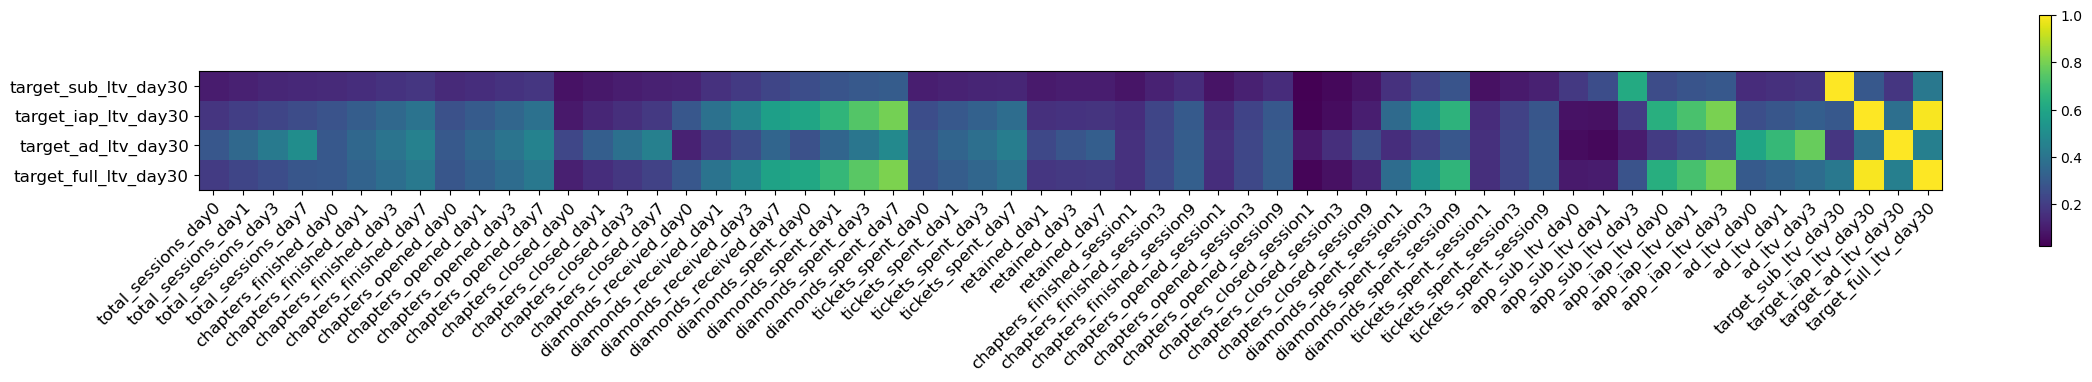

In [9]:
fig, ax = plt.subplots(figsize=(25, 3))
im = ax.imshow(selected_corr, interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction = 0.05)

ax.set_xticks(np.arange(len(selected_corr.columns)))
ax.set_yticks(np.arange(len(selected_corr.index)))
ax.set_xticklabels(selected_corr.columns, fontsize=12)
ax.set_yticklabels(selected_corr.index, fontsize=12)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

З наведеного вище графіку можна визначити, які дані найбільше взаємопов'язні.
* Доходи з підписок не має значних зв'язків з іншими стовпцями, окрім очевидного зв'язку з кумулятивними доходами від придбання підписок.
* Доходи з покупки кристалів і тікетів найбільше корелюють з кумулятивними витратами кристалів, витратами кристалів за сесію й отриманням кристалів.
* Доходи з реклами є помітно більш взаємопов'язаними, ніж інші види доходів, з кількістю сесій, закритих глав, дней повернення й закритих глав за сесію.
* Загальних дохід має кореляцію близьку до 1.0 з доходами з покупки кристалів і тікетів, тому можна зробити висновок, що більшу кількість прибутку забезпечують саме вони. Це підтверджує те, що їх кореляції з іншими стовпцями майже ідентичні.

Далі розглянемо графіки найбільш корельованих з цільовою змінною стовпців.

In [7]:
def show_graphic(n, diff=False, *args):
    if diff:
        fig, ax = plt.subplots(1, n-1, figsize=(25, 9-n))
        prev = False
    
        for i, arg in enumerate(args):
            if prev:
                ax[i-1].scatter(data[arg] - data[prev], data['target_full_ltv_day30'], alpha=0.3)
                ax[i-1].set(xlabel=arg + '-' + prev[-1], ylabel='target_full_ltv_day30')
                prev = arg
            else:
                prev = arg
    else:
        fig, ax = plt.subplots(1, n, figsize=(25, 9-n))
    
        for i, arg in enumerate(args):
            ax[i].scatter(data[arg], data['target_full_ltv_day30'], alpha=0.3)
            ax[i].set(xlabel=arg, ylabel='target_full_ltv_day30')
        
    plt.show()

Побудуємо графіки залежності загального дохода від витрачених за N днів кристалів.

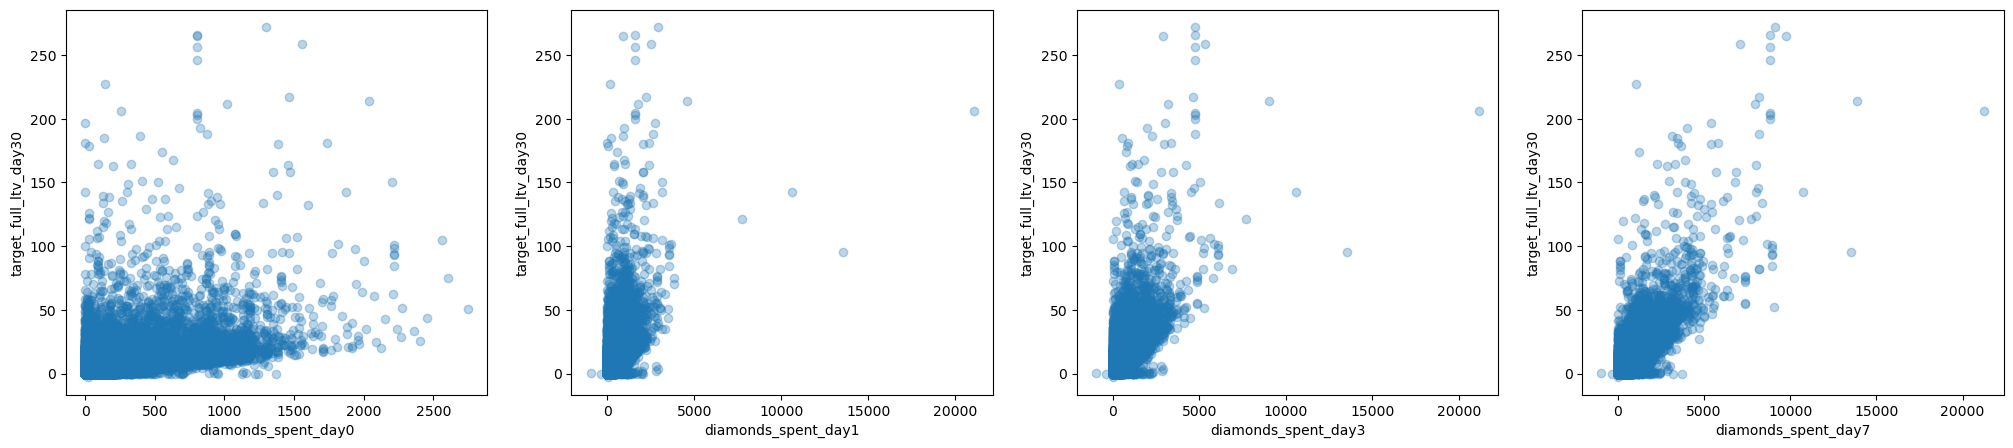

In [30]:
show_graphic(4, False, 'diamonds_spent_day0', 'diamonds_spent_day1', 'diamonds_spent_day3', 'diamonds_spent_day7')

І витрачених за сесію M кристалів.

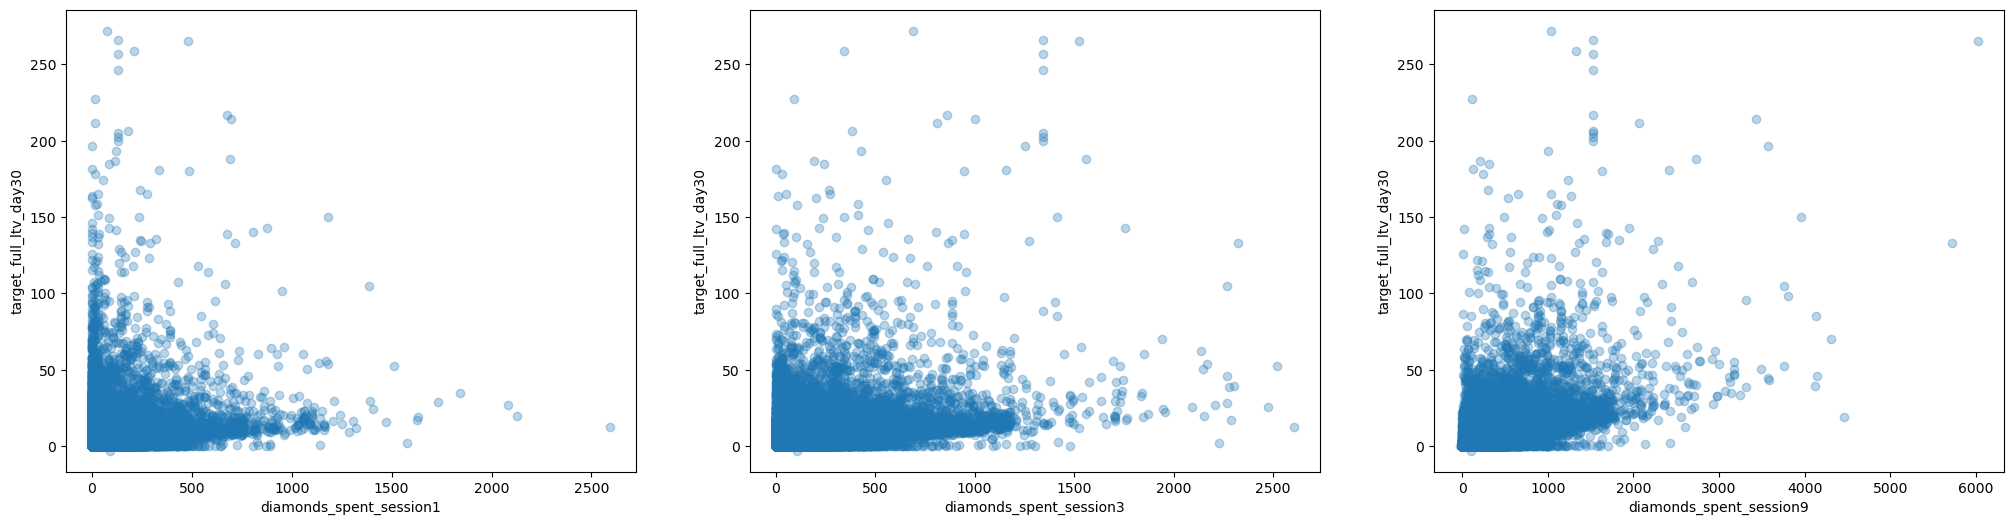

In [31]:
show_graphic(3, False, 'diamonds_spent_session1', 'diamonds_spent_session3', 'diamonds_spent_session9')

Як можна побачити з графіків, основна маса даних (десятки тисячі точок) скупчені в певних областях, за межами яких є викиди з аномально великими значеннями. Але, як було зазначено вище, для мобільних ігор є звичним, коли "1% гравців дає 99% прибутків", тому ці викиди ми вирішили ніяк не обробляти, але матимемо на увазі під час feature engineering.


Під час аналізу графіків, ми висунули припущення, що різниця між певними стовпцями може підсилювати неочевидні закономірності в даних. Тому додавання стовпців з різницями до навчального набору даних може "звернути увагу" моделі на ці закономірності й покращити її результати. Далі ми ще перевіремо це припущення.

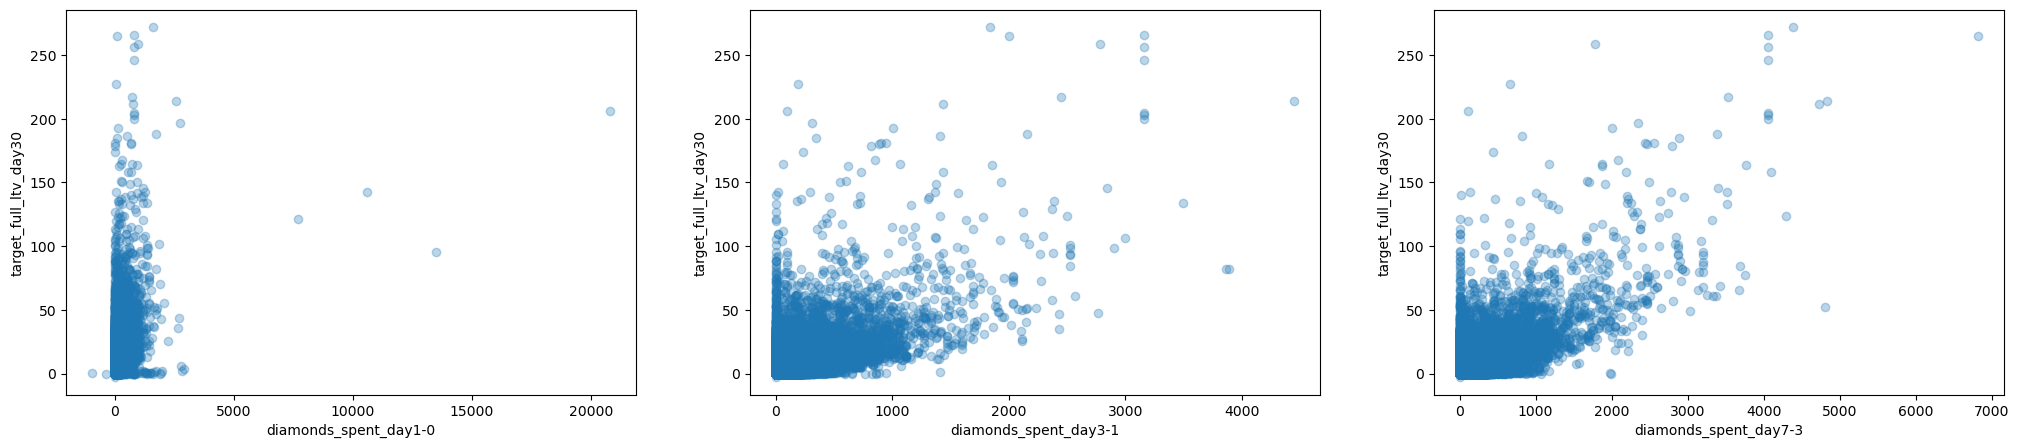

In [32]:
show_graphic(4, True, 'diamonds_spent_day0', 'diamonds_spent_day1', 'diamonds_spent_day3', 'diamonds_spent_day7')

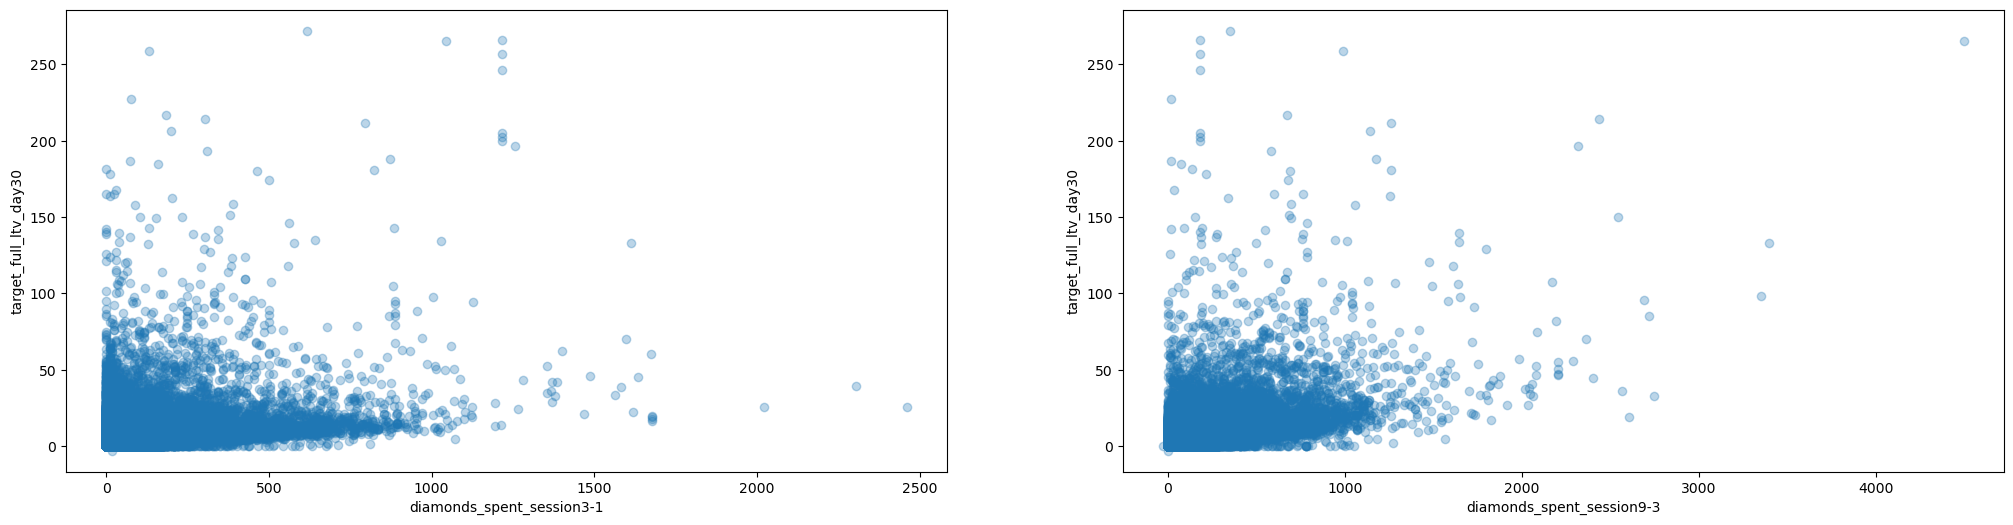

In [34]:
show_graphic(3, True, 'diamonds_spent_session1', 'diamonds_spent_session3', 'diamonds_spent_session9')

З цих графіків можна отримати велику кількість корисної інформації про дані:
* залежність середніх значень таргету від інтервалів колонок схожа на експоненційний розподіл,
* при збільшенні середнього доходу кількість користувачів які приносять цей дохід значно зменшується,
* додавання додаткових штучних колонок приналежності до певного інтервалу може покращити результат через "підказку" моделі, бо таким чином вона зможе вивчити статистичні дані за кожним інтервалом окремо, а не покладатися на лише цілі та float значення, які при такому розподілі будуть давати менш точні передбачення таргету.

Тепер розглянемо кожен графік окремо, та спробуємо зробити нові висновки чи підкріпити старі:
* чим більше користувач приніс прибутку з реклами за перший день, тим, ймовірно, більше принесе за 30 днів загального прибутку,
* тенденція не є такою чіткою на день 1 та день 3, але проте середнє значення загального доходу в останніх інтервалах у декілька разів більше, ніж у перших,
* така ж чітка тенденція прослідковується з кількості купівлі кристалів та тікетів у перші дні.

## Трансформація даних перед навчанням

Є гіпотеза позбавитися стовпця install_date, оскільки його значення ніколи не будуть повторюватися в майбутньому і навчання на даних з ним буде мати тенденцію до перенавчання, але спочатку перевіримо залежність значення цільової змінної від кількості днів з встановлення додатку. За "найсвіжішу" дату візьмемо максимальну наявну в даних.

In [9]:
from datetime import datetime
max_date = data['install_date'].max()

def days_between(d1):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(max_date, "%Y-%m-%d")
    return abs((d2 - d1).days)

print(f'Difference between max and min date: ', days_between(data['install_date'].min()))

Difference between max and min date:  61


Створимо окрему колонку з кількістю днів від встановлення до максимальної дати у даних.

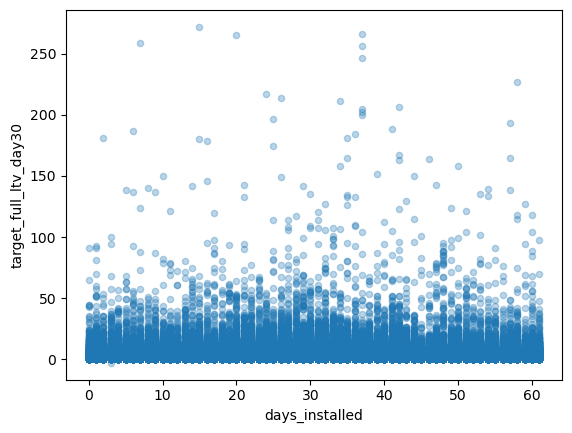

In [11]:
data['days_installed'] = data['install_date'].apply(days_between)

data.plot.scatter('days_installed', 'target_full_ltv_day30', alpha=0.3)

Складно побачити bins = pd.IntervalIndex.from_tuples([(-1,5), (5, 10), (10,15), (15, 20), (20,25),
                                     (25,30), (30,40), (40,50), (50,np.inf)]) закономірності, спробуємо згрупувати за інтервалами та знайти середнє значення таргету.

C:\Users\miyatna\AppData\Local\Temp\ipykernel_2964\829126290.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  x = ax[0].set_xticklabels(data_grouped.index.astype('str'), fontsize=10)
C:\Users\miyatna\AppData\Local\Temp\ipykernel_2964\829126290.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  x = ax[1].set_xticklabels(data_grouped.index.astype('str'), fontsize=10)


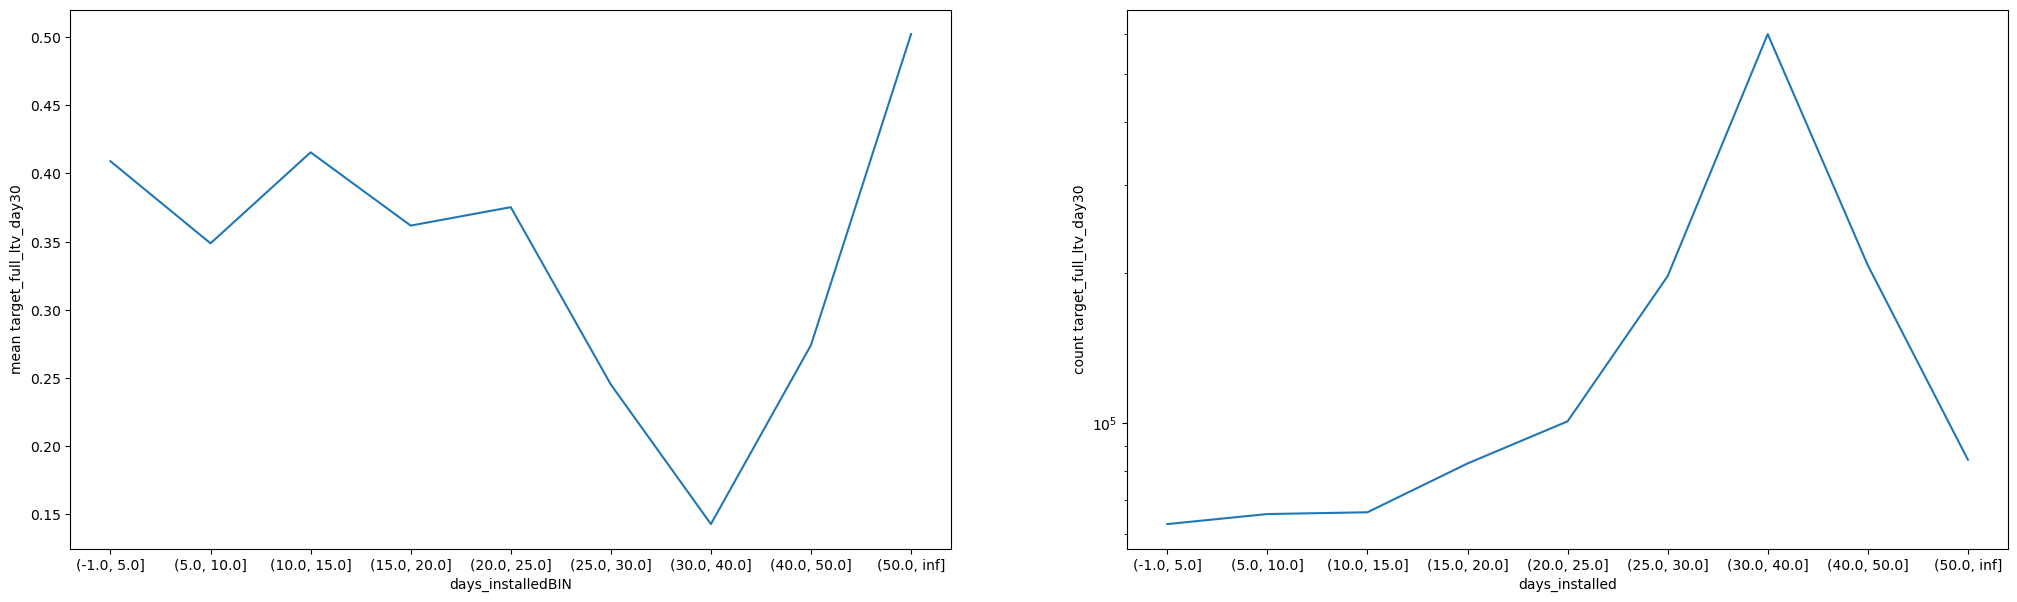

In [12]:
bins = pd.IntervalIndex.from_tuples([(-1,5), (5, 10), (10,15), (15, 20), (20,25),
                                     (25,30), (30,40), (40,50), (50,np.inf)])

data['days_installedBIN'] = pd.cut(data['days_installed'], bins)
data_temp = data[['days_installedBIN', 'target_full_ltv_day30']].copy()
data.drop(columns=['days_installedBIN',], inplace=True)
data_grouped = data_temp.groupby('days_installedBIN').agg(["mean", "count"])

fig, ax = plt.subplots(1, 2, figsize=(25, 7))

x = ax[0].set_xticklabels(data_grouped.index.astype('str'), fontsize=10)
x = ax[0].plot(data_grouped.index.astype('str'), data_grouped[('target_full_ltv_day30','mean')])
x = ax[0].set_xlabel('days_installedBIN')
x = ax[0].set_ylabel('mean target_full_ltv_day30')

x = ax[1].set_xticklabels(data_grouped.index.astype('str'), fontsize=10)
x = ax[1].plot(data_grouped.index.astype('str'), data_grouped[('target_full_ltv_day30','count')])
x = ax[1].set_yscale('log')
x = ax[1].set_xlabel('days_installed')
x = ax[1].set_ylabel('count target_full_ltv_day30')

plt.show()

Хоча і є певний вплив, він не є настільки значним, щоб включати ці дані до робастної моделі, оскільки не має впевненності, що при використанні даних з іншого часового простору цей розподіл не зміниться кардинально.

In [13]:
data.drop(columns=['install_date'], inplace=True)

Напишемо функції для трансформації даних.

In [14]:
categories = ['country_code', 'platform', 'media_source']

non_decreasing_cum_cols_start_with = [
    #day
    'total_sessions_day', 'chapters_finished_day', 'chapters_opened_day',
    'chapters_closed_day', 'diamonds_received_day', 'diamonds_spent_day',
    'tickets_spent_day',
    #session
    'chapters_finished_session', 'chapters_opened_session',
    'chapters_closed_session', 'diamonds_spent_session', 'tickets_spent_session',
    #incomes
    'app_sub_ltv_day', 'app_iap_ltv_day', 'ad_ltv_day'
]

def divide_df(df_t):
    target_cols = [col for col in df_t.columns if col.startswith('target')]
    targets_df = df_t[target_cols]
    df_t.drop(columns=target_cols, inplace=True)
    return targets_df

def generate_differences(df_t):
    for el in non_decreasing_cum_cols_start_with:
        arr = [col[-1] for col in df_t.columns if col.startswith(el)]
        
        for i in range(len(arr)):
            for j in range(i + 1, len(arr)):
                df_t[el + arr[j] + '-' + el + arr[i]] = df_t[el + arr[j]] - df_t[el + arr[i]]
                
    return df_t

* Функція divide_df видаляє усі чотири цільові стовпчики з набору даних і повертає їх.
* Функція generate_differences генерує стовпці з різницями.

In [17]:
data_targets = divide_df(data)
data = generate_differences(data)
data= pd.get_dummies(data)

data.columns

Index(['total_sessions_day0', 'total_sessions_day1', 'total_sessions_day3',
       'total_sessions_day7', 'chapters_finished_day0',
       'chapters_finished_day1', 'chapters_finished_day3',
       'chapters_finished_day7', 'chapters_opened_day0',
       'chapters_opened_day1',
       ...
       'country_code_COUNTRY_92', 'country_code_COUNTRY_93',
       'country_code_COUNTRY_94', 'country_code_COUNTRY_95',
       'country_code_COUNTRY_96', 'country_code_COUNTRY_97',
       'country_code_COUNTRY_98', 'country_code_COUNTRY_99',
       'platform_android', 'platform_ios'],
      dtype='object', length=372)

Тепер маємо 125 стовпців.

## Навчання моделей

Остаточним нашим вибором став алгоритм CatBoostRegressor. Як було зазначено вище, через велику кількість нулів у цільовій змінній, головну метрику ми обирали поміж RMSE та MAE. Основною їх різницею є те, що RMSE штрафує за більші помилки сильніше, а MAE легше інтерпретується. Було вирішено, що особливість RMSE може бути корисною в контексті задачі. 


Ми орієнтувалися на обидві метріки, але обрати RMSE в якості тої, за якою буде обиратися найкраща модель. 


Спробуємо порівняти результати моделі на декількох етапах трансформації даних:
<ol>
<li>Чисті дані.</li>
<li>Дані з різницями по стовпцях.</li>
</ol>

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data, data_targets['target_full_ltv_day30'], test_size=0.1, shuffle=True, random_state=42)

case1_columns = [col for col in data.columns if '-' not in col]
case2_columns = data.columns

cases = {'Raw data': case1_columns,
         'Data with difference columns': case2_columns}

for name, cols in cases.items():
    print(name)
    
    model = CatBoostRegressor(task_type='GPU', verbose=False, iterations=5000, l2_leaf_reg=5)
    model.fit(X_train[cols], y_train)
    
    predictions_train = model.predict(X_train[cols])
    predictions_test = model.predict(X_test[cols])
    
    print(f'Train RMSE: {np.sqrt(mean_squared_error(y_train, predictions_train))} '
          f'MAE: {mean_absolute_error(y_train, predictions_train)}')

    print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test, predictions_test))} '
          f'MAE: {mean_absolute_error(y_test, predictions_test)}\n')

Raw data
Train RMSE: 0.552254946216136 MAE: 0.06749038594705832
Test RMSE: 0.9798919905525937 MAE: 0.0806735073761062

Data with difference columns
Train RMSE: 0.5155347629399167 MAE: 0.06423267770644549
Test RMSE: 0.8790921324567832 MAE: 0.07585318376569906



## Інтерпретація метрік моделей

Дізнатися чи дійсно моделі показують гарний результат можна за допомогою метріки MAE. Вона розшифровується як mean absolute error і відбражає математичне сподівання модуля помилки для кожного передбачення моделі. Значення цільової змінної знаходиться у межах від 0 до 272 і має математичне сподівання 0.257, тому MAE > 0.08 може бути прийнятним для stake-owners.
model = CatBoostRegressor(task_type='GPU', verbose=False, iterations=5000, l2_leaf_reg=5)
    
Як можна побачити з оцінок обох моделей на тренувальних і тестових даних, навчена на даних з різницевими стовпцями модель показує трохи кращий результат без ознак перенавчання, тому оберемо її як найкращу модель і навчимо ще раз з нуля на усіх даних.

In [42]:
model = CatBoostRegressor(task_type='GPU', verbose=False, iterations=5000, l2_leaf_reg=5)
model.fit(data, data_targets['target_full_ltv_day30'])
    
predictions_train = model.predict(data)
    
print('Train RMSE: ', np.sqrt(mean_squared_error(data_targets['target_full_ltv_day30'], predictions_train)),
      'MAE: ', mean_absolute_error(data_targets['target_full_ltv_day30'], predictions_train))

Train RMSE:  0.522477422728841 MAE:  0.06365870051744847


In [43]:
model.save_model('best_model')

Подивимося як різні стовпці вливають на прогноз моделі.

In [44]:
model = CatBoostRegressor(task_type='GPU', verbose=False, iterations=5000, l2_leaf_reg=5)
model.load_model('best_model')

def plot_feature_importance(importance, names, model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(20,20))
    
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:30], y=fi_df['feature_names'][:30])
    
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

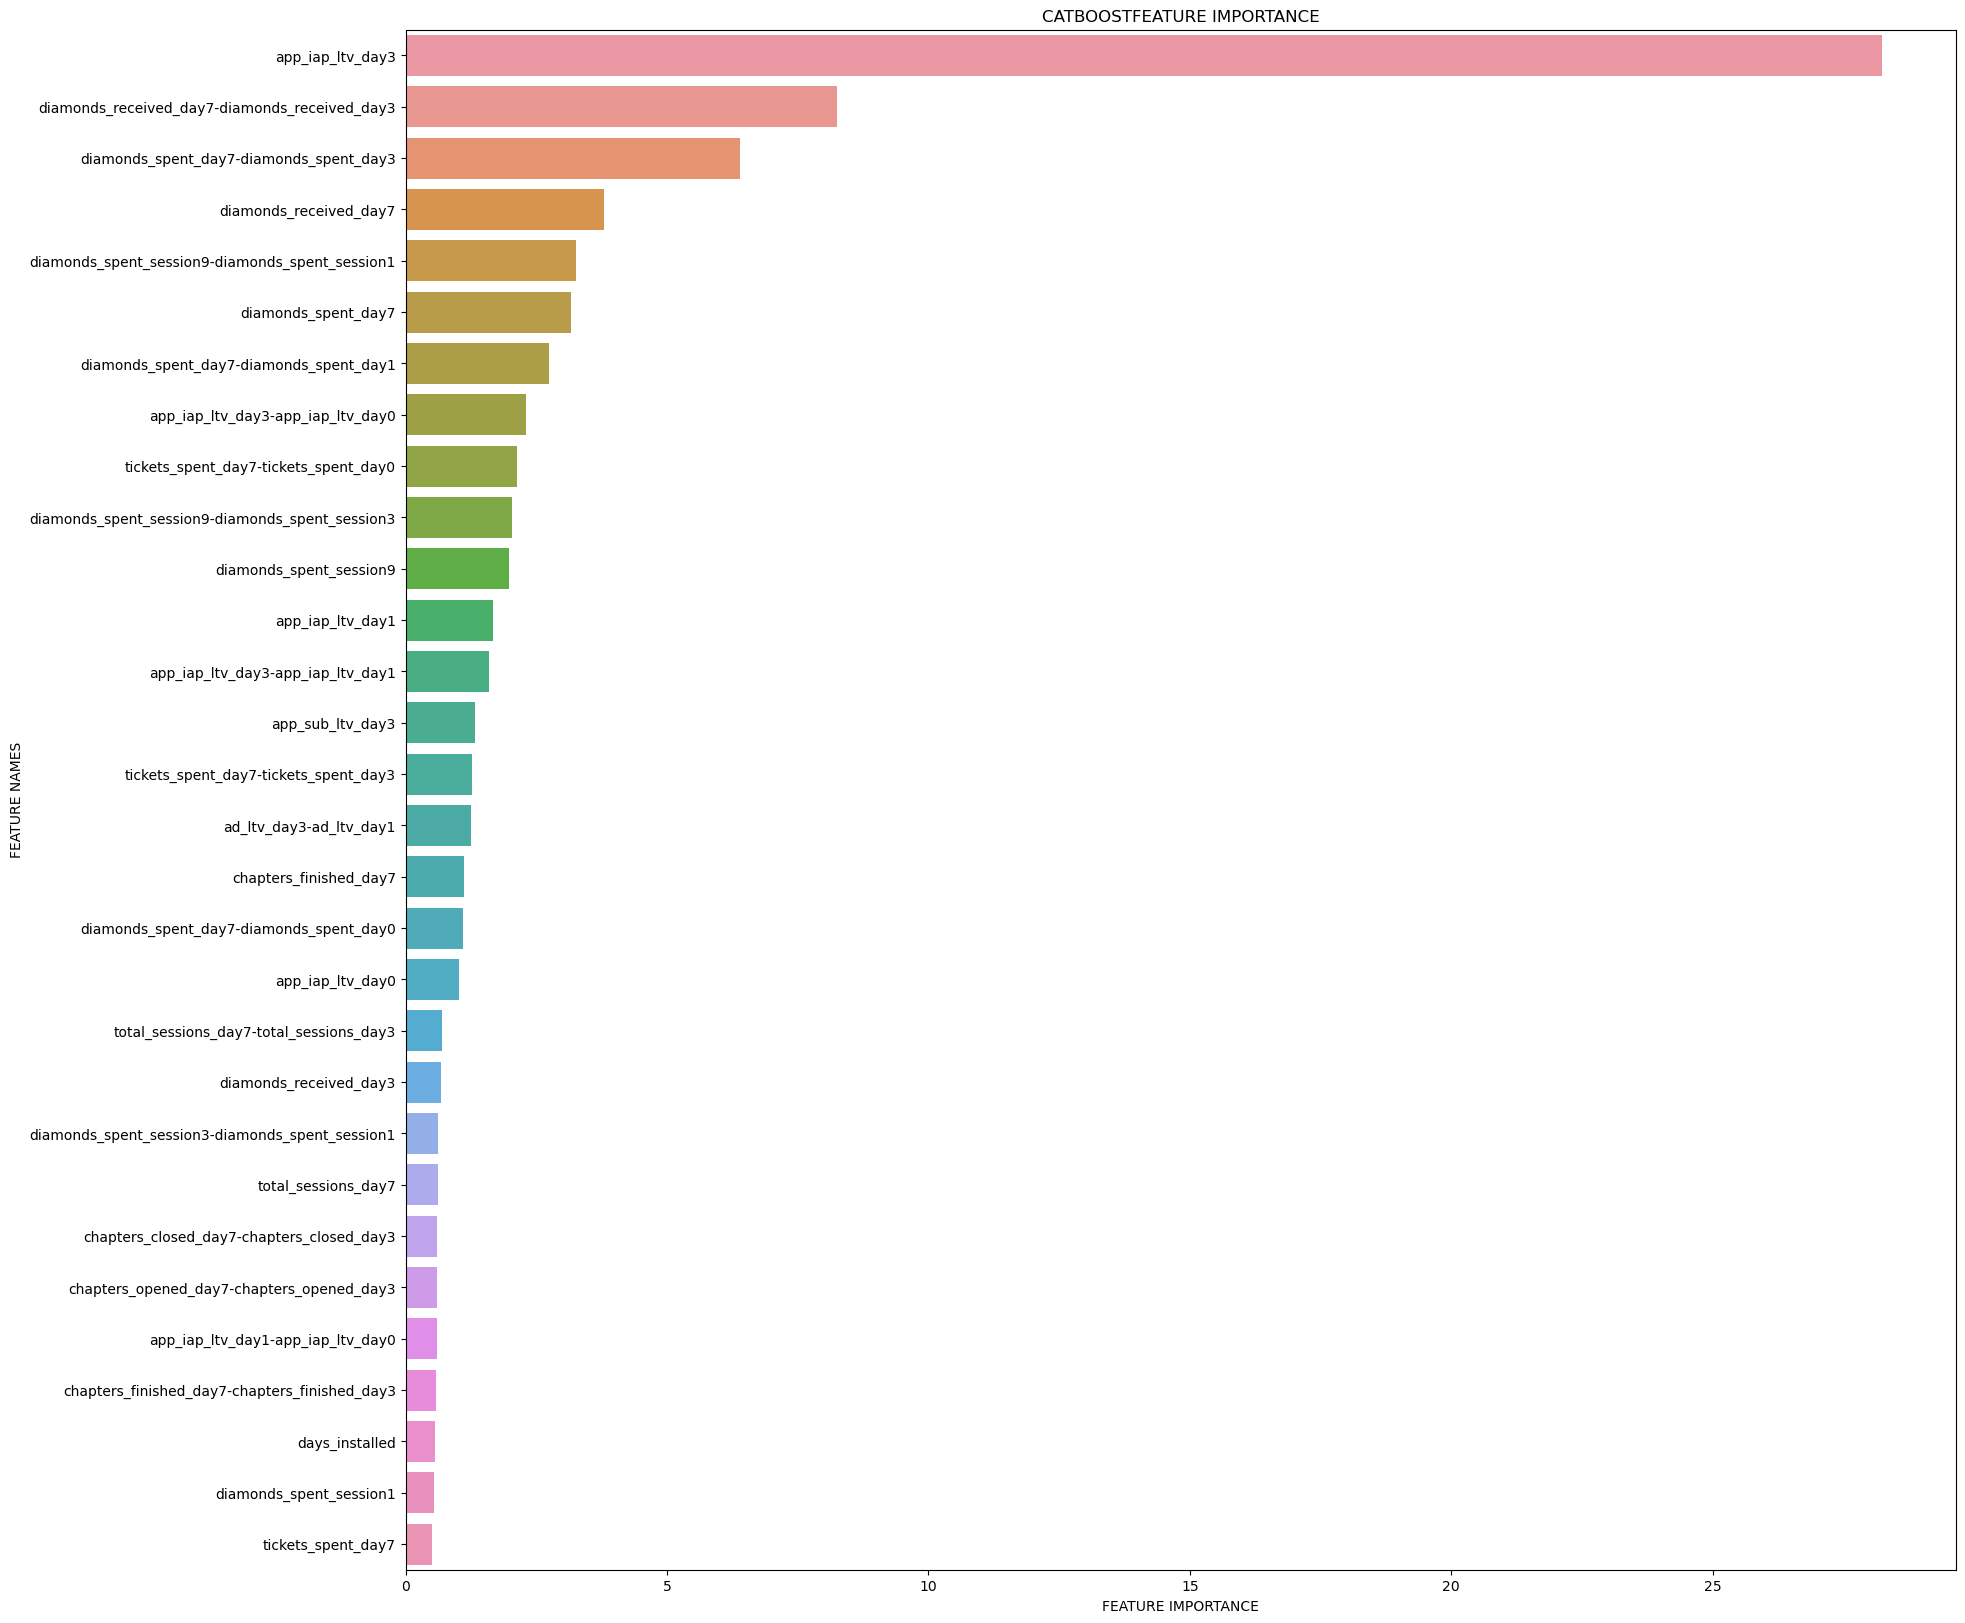

In [45]:
plot_feature_importance(model.get_feature_importance(),data.columns,'CATBOOST')

Як можна побачити з графіку, найбільший вплив мають:
* кумулятивна сума доходів з придбання кристалів і тікетів,
* різниця між кількістю крісталів, отриманих в день 7 і 3,
* різниця між кількістю крісталів, витрачених в день 7 і 3,
* крістали, отримані в день 7.